In [90]:
# Import Libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf
import pandas as pd
import numpy as np 
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [91]:
# List of Symbols for the Stocks
stock_list = [
    'ETH-USD',  # Ethereum
]
# Create an empty list to hold dataframes
all_data = []
for stock in stock_list:
    stock_symbol = yf.Ticker(stock)
    stock_data = stock_symbol.history(period="1y", interval='1d', actions=True)
    stock_data.reset_index(inplace=True)
    stock_data['stock_name'] = stock
    
    # Fetch fundamental data
    stock_info = stock_symbol.info
    stock_data['sector'] = stock_info.get('sector', 'N/A')
    stock_data['industry'] = stock_info.get('industry', 'N/A')
    stock_data['market_cap'] = stock_info.get('marketCap', 'N/A')
    
    # Add to list
    all_data.append(stock_data)

In [92]:
# Combine all data into one DataFrame
combined_data = pd.concat(all_data, ignore_index=True)

In [93]:
# Seperate Data by today's data and the past
today_data = combined_data.iloc[-1]

# Remove today's data from the dataset
past_data = combined_data.drop(index=today_data.name)

In [94]:
# Step 1: Calculate the daily returns
past_data['Return'] = past_data['Close'].diff()

# Step 2: Calculate gains and losses
past_data['Gain'] = past_data['Return'].where(past_data['Return'] > 0, 0)
past_data['Loss'] = -past_data['Return'].where(past_data['Return'] < 0, 0)

# Step 3: Calculate the rolling average of gains and losses
window = 14  # 14-day period commonly used for RSI
avg_gain = past_data['Gain'].rolling(window=window).mean()
avg_loss = past_data['Loss'].rolling(window=window).mean()

# Step 4: Calculate the Relative Strength (RS)
RS = avg_gain / avg_loss

# Step 5: Calculate RSI
past_data['RSI'] = 100 - (100 / (1 + RS))

# View the result
print(past_data[['Close', 'RSI']].tail())  

           Close        RSI
361  3883.101562  61.675601
362  3911.205322  62.096447
363  3868.405273  56.540282
364  3951.941162  59.107157
365  3987.480957  63.300581


In [95]:
# Create a candlestick plot using Plotly
fig = go.Figure(data=[go.Candlestick(x=past_data['Date'],
                                     open=past_data['Open'],
                                     high=past_data['High'],
                                     low=past_data['Low'],
                                     close=past_data['Close'])])

fig.update_layout(title='Ethereum Price Over Time',
                  xaxis_title='Date',
                  yaxis_title='Price (USD)')

# Show the plot
fig.show()

### Statistical Analysis

In [96]:
# Calculate ACF and PACF
acf_values = acf(past_data['Close'], nlags=40)  # You can adjust the number of lags
pacf_values = pacf(past_data['Close'], nlags=40)  # You can adjust the number of lags

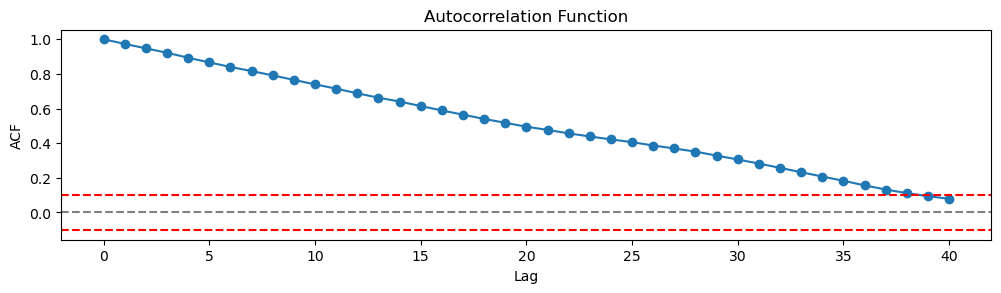

In [97]:
# Plot ACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(acf_values, marker='o')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=-1.96 / np.sqrt(len(past_data)), color='red', linestyle='--')  # 95% confidence interval
plt.axhline(y=1.96 / np.sqrt(len(past_data)), color='red', linestyle='--')   # 95% confidence interval
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

#### Analysis suggest that there is significant autocorrelation at these lags, therefore, the past values are strongly influencing future ones

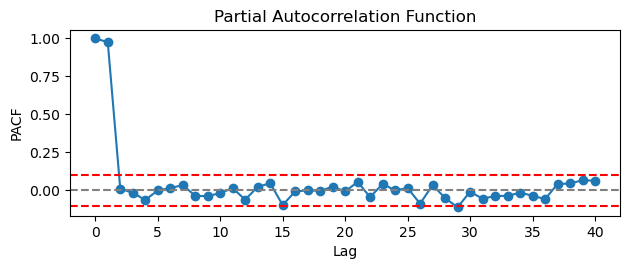

In [98]:
# Plot PACF
plt.subplot(212)
plt.plot(pacf_values, marker='o')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=-1.96 / np.sqrt(len(past_data)), color='red', linestyle='--')  # 95% confidence interval
plt.axhline(y=1.96 / np.sqrt(len(past_data)), color='red', linestyle='--')   # 95% confidence interval
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()

#### Analysis of the PACF test provide information that the there is no significant direct relationship betwen the series and its lags.

In [99]:
# Perform the ADF test
adf_result = sm.tsa.adfuller(past_data['Close'])

# Print the results
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values:\n{adf_result[4]}")

ADF Statistic: -1.6892170207196557
p-value: 0.43667658046224217
Critical Values:
{'1%': -3.4483935212959844, '5%': -2.8694912343676497, '10%': -2.571005879151811}


#### With the high p-value and ADF statistic, it can be condcluded that the data is not stationary. 

## Making it Stationary

In [100]:
# Perform first differencing
data_diff = past_data['Close'].diff().dropna()

# Check ADF test on differenced data
diff_adf_result = sm.tsa.adfuller(data_diff)
print(f"Differenced ADF Statistic: {diff_adf_result[0]}")
print(f"Differenced p-value: {diff_adf_result[1]}")


Differenced ADF Statistic: -19.39606211932184
Differenced p-value: 0.0


#### Data is stationary

In [101]:
# Prepare sequences
def create_sequences(data, look_back=5):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

In [102]:
look_back = 5
X, y = create_sequences(data_diff, look_back=look_back)

In [103]:
# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [104]:
# Scale features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(look_back, 1)),
    Dense(1)
])

/Users/daviddiaz/anaconda3/envs/local_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [105]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [106]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1430 - val_loss: 0.0739
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0643 - val_loss: 0.0171
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0138 - val_loss: 0.0116
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - val_loss: 0.0122
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0152 - val_loss: 0.0084
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0092
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - val_loss: 0.0084
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - val_loss: 0.0081
Epoch 13/100

In [107]:
# Print out the Loss of the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test loss: {loss}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6756e-05 
Test loss: 4.67821373604238e-05


In [108]:
# Predict on the test set
y_pred = model.predict(X_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Mean Squared Error (MSE): 42.43262291718136
Root Mean Squared Error (RMSE): 6.514032769120935


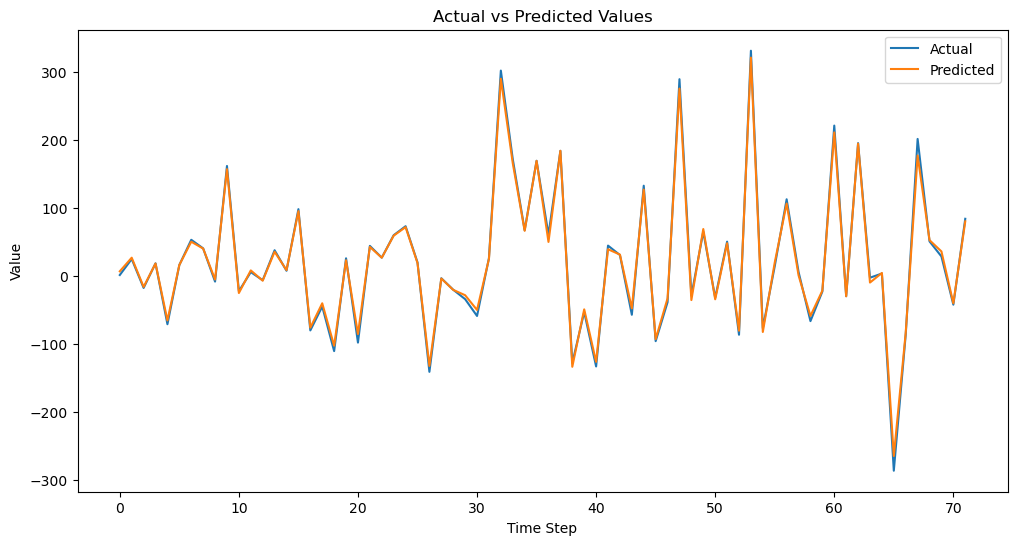

In [109]:
# Convert predictions back to the original scale
y_pred_original_scale = scaler_y.inverse_transform(y_pred)
y_test_original_scale = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
# Calculate MSE
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
print(f"Mean Squared Error (MSE): {mse}")
rmse = root_mean_squared_error(y_test_original_scale, y_pred_original_scale)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_original_scale, label='Actual')
plt.plot(y_pred_original_scale, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

### Today's Data

In [110]:
today_data

Date            2024-12-17 00:00:00+00:00
Open                           3986.86792
High                          4038.815186
Low                           3851.333008
Close                         3878.481689
Volume                        35240976384
Dividends                             0.0
Stock Splits                          0.0
stock_name                        ETH-USD
sector                                N/A
industry                              N/A
market_cap                   467167412224
Name: 366, dtype: object

In [117]:
# Prepare input for LSTM prediction
last_sequence = np.array(today_data['Close']).reshape(1, look_back, 1)  # Reshape for LSTM
last_sequence_scaled = scaler_X.transform(last_sequence)  # Transform the sequence using the scaler
# Make prediction
next_day_prediction_scaled = model.predict(last_sequence_scaled)

# Convert prediction back to original scale
next_day_prediction = scaler_y.inverse_transform(next_day_prediction_scaled)
print(f"Predicted Value for the Next Day: {next_day_prediction[0][0]}")

ValueError: cannot reshape array of size 1 into shape (1,5,1)